In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# loading postcode data
postcode_gdf = gpd.read_file("data/postcode/AMTOVZ_ZIP.shp")
postcode_info = pd.read_csv("data/postcode/AMTOVZ_ZIP.csv", delimiter=';', dtype={'ZIP4': str})
info_2024 = pd.read_csv("data/cleaned/ga_hta_socioeconomic_2024.csv", dtype={'postcode': str})

# Keep only one row per postcode from CSV
postcode_info = postcode_info[postcode_info['Zusatzziffer'] == '00'].copy()
postcode_info = postcode_info[['PLZ', 'Ortschaftsname', 'Gemeindename', 'Kantonskürzel', 'E', 'N']]
postcode_info.rename(columns={'PLZ': 'postcode'}, inplace=True)

postcode_gdf['postcode'] = postcode_gdf['ZIP4'].astype(str)
gdf_merged = postcode_gdf.merge(postcode_info, on='postcode', how='left')
gdf_merged = gdf_merged.merge(info_2024, on='postcode', how='left')


In [2]:
postcode_info = pd.read_csv("data/postcode/AMTOVZ_ZIP.csv", delimiter=';', dtype={'ZIP4': str})
postcode_info

Ortschaftsname   PLZ  Zusatzziffer        Gemeindename  BFS-Nr  \
0        Aeugst am Albis  8914             0     Aeugst am Albis       1   
1            Aeugstertal  8914             2     Aeugst am Albis       1   
2              Zwillikon  8909             0  Affoltern am Albis       2   
3     Affoltern am Albis  8910             0  Affoltern am Albis       2   
4             Bonstetten  8906             0          Bonstetten       3   
...                  ...   ...           ...                 ...     ...   
5759           Mauren FL  9493             0              Mauren    7008   
5760             Nendeln  9485             0             Gamprin    7009   
5761     Gamprin-Bendern  9487             0             Gamprin    7009   
5762             Ruggell  9491             0             Ruggell    7010   
5763        Schellenberg  9488             0        Schellenberg    7011   

     Kantonskürzel            E            N Sprache    Validity  
0               ZH  2679402.872  1235842.010      de  2008-07-01  
1               ZH  2679815.372  1237404.310      de  2008-07-01  
2               ZH  2675280.133  1238108.286      de  2008-07-01  
3               ZH  2676852.012  1236929.718      de  2008-07-01  
4               ZH  2677412.150  1241078.278      de  2008-07-01  
...            ...          ...          ...     ...         ...  
5759           NaN  2759637.820  1231945.121      de  2008-07-01  
5760           NaN  2759978.270  1229651.126      de  2008-07-01  
5761           NaN  2757125.670  1232514.364      de  2008-07-01  
5762           NaN  2758648.719  1235172.319      de  2008-07-01  
5763           NaN  2759708.282  1233349.815      de  2008-07-01  

[5764 rows x 10 columns]

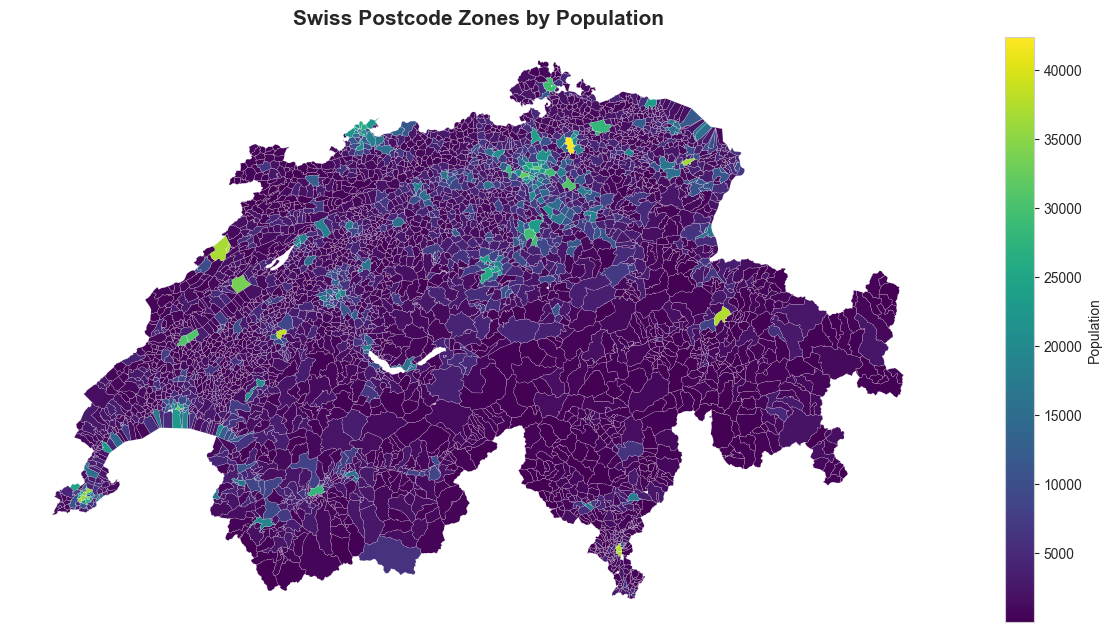

In [3]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_merged.plot(
    column='population',
    cmap='viridis',
    linewidth=0.1,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={'label': "Population", 'shrink': 0.5}
)
ax.set_title("Swiss Postcode Zones by Population", fontsize=15, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

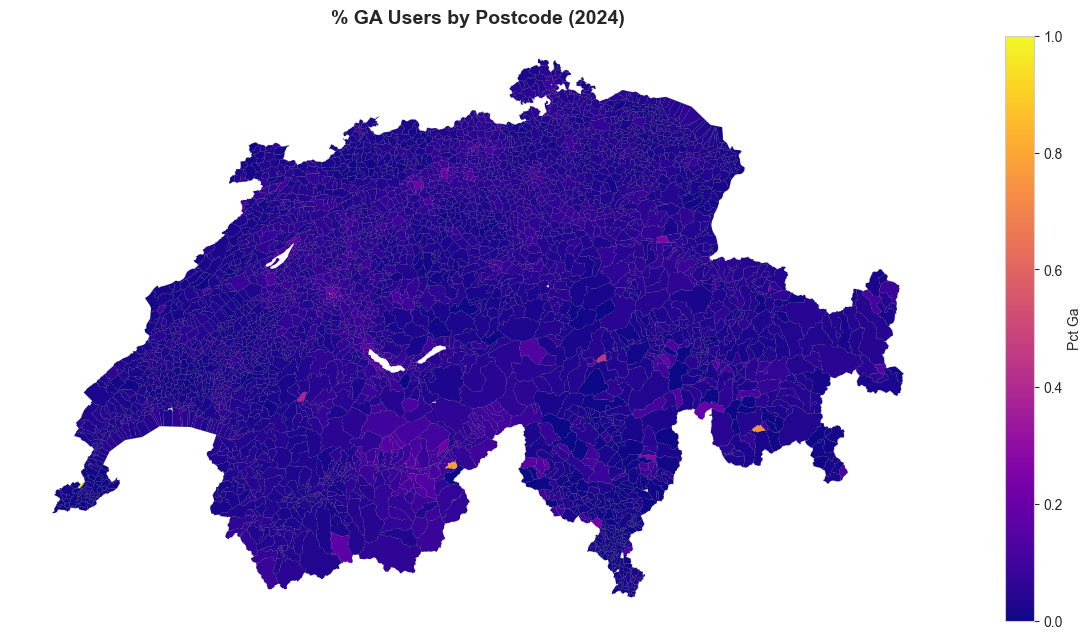

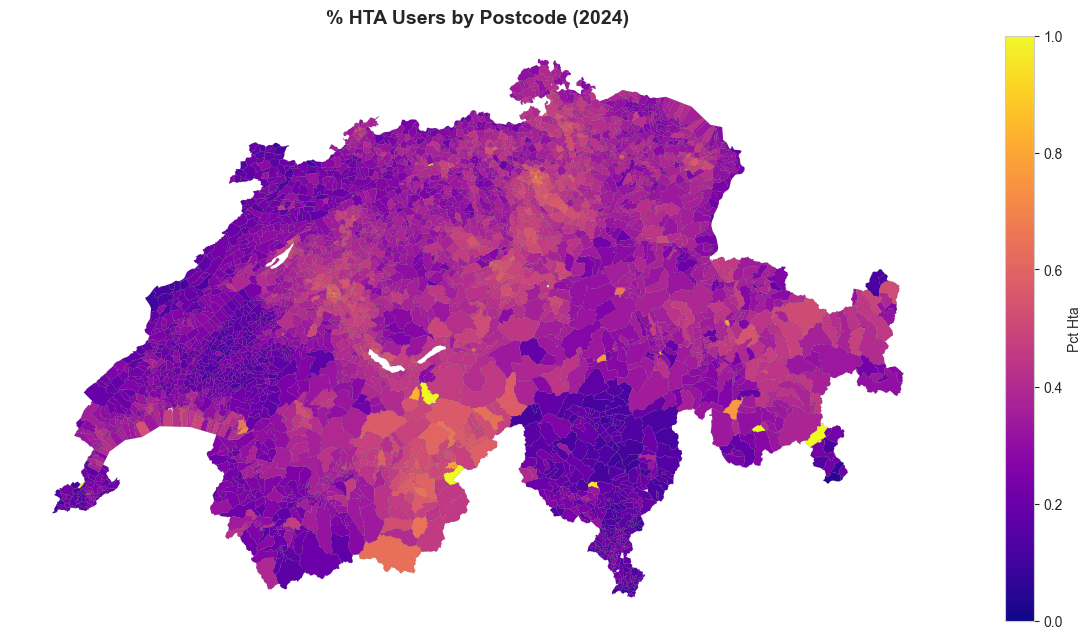

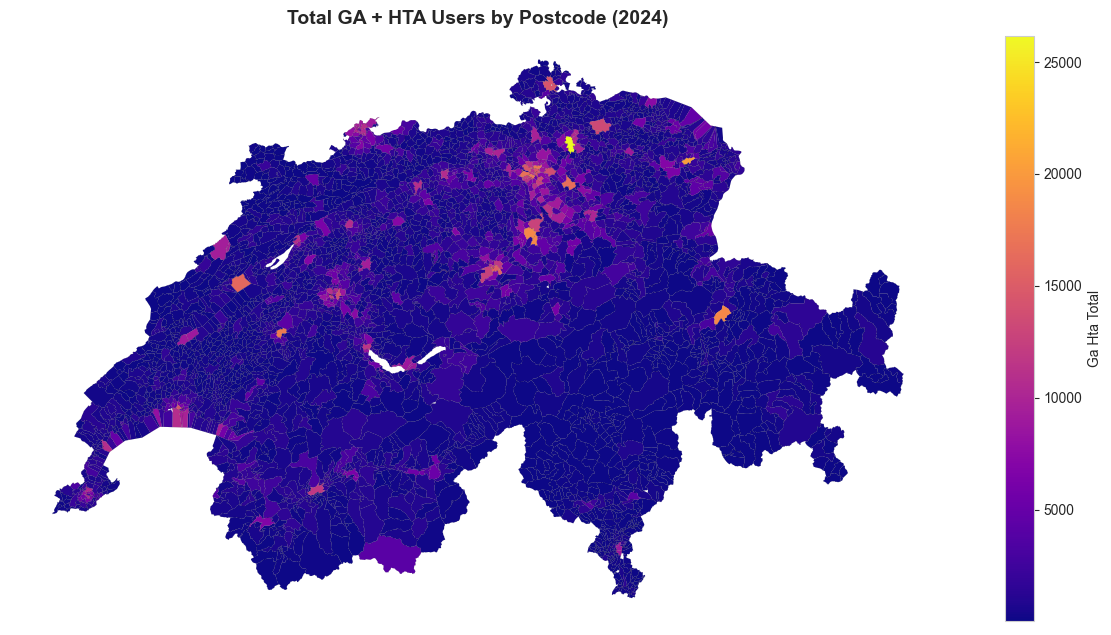

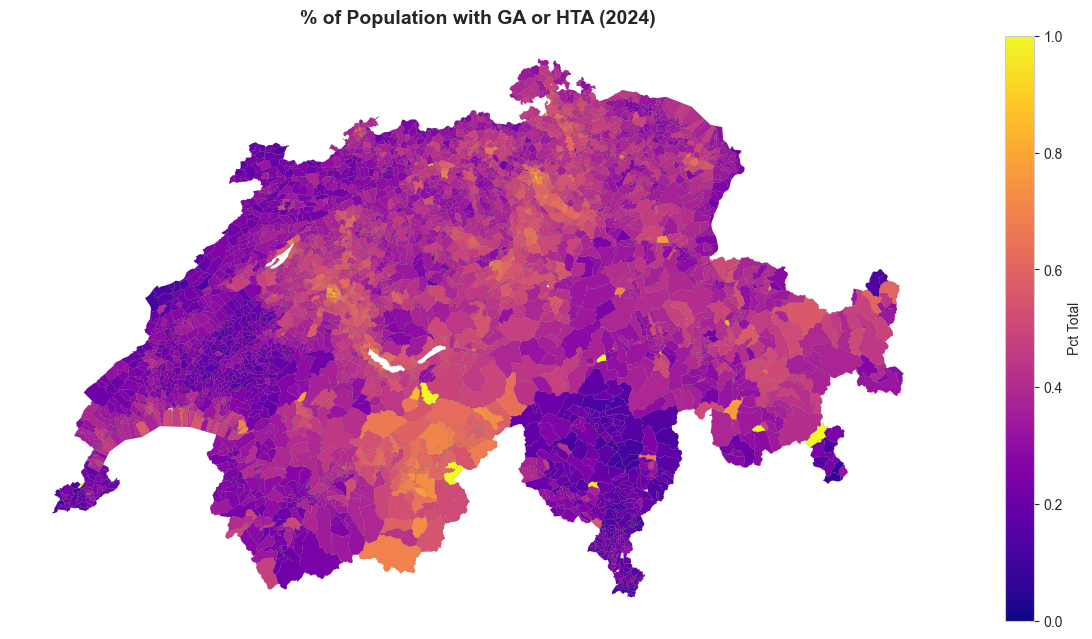

In [6]:
gdf_merged['pct_ga'] = (gdf_merged['GA'] / gdf_merged['population'])
gdf_merged['pct_hta'] = (gdf_merged['HTA'] / gdf_merged['population'])
gdf_merged['ga_hta_total'] = gdf_merged['GA'] + gdf_merged['HTA']
gdf_merged['pct_total'] = gdf_merged['ga_hta_total'] / gdf_merged['population']

def plot_map(df, column, title, cmap='plasma', vmin=None, vmax=None, legend=True, terr=True):
    fig, ax = plt.subplots(figsize=(12, 12))
    df.plot(
        column=column,
        cmap=cmap,
        linewidth=0.05,
        ax=ax,
        edgecolor='black',
        legend=legend,
        legend_kwds={'label': column.replace("_", " ").title(), 'shrink': 0.5},
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    if terr:
        plt.show()

plot_map(gdf_merged, 'pct_ga', "% GA Users by Postcode (2024)", vmax=1, vmin=0)
plot_map(gdf_merged, 'pct_hta', "% HTA Users by Postcode (2024)", vmax=1, vmin=0)
plot_map(gdf_merged, 'ga_hta_total', "Total GA + HTA Users by Postcode (2024)")
plot_map(gdf_merged, 'pct_total', "% of Population with GA or HTA (2024)", vmax=1, vmin=0)

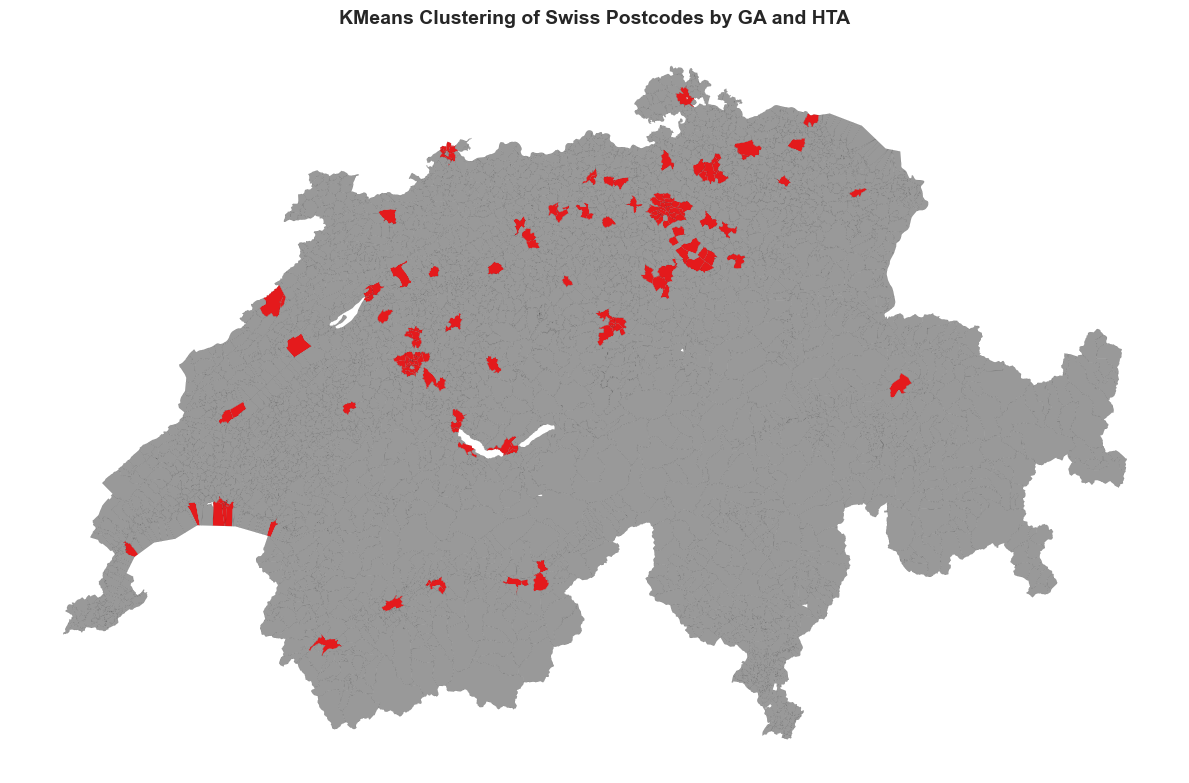

In [19]:
import geopandas
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
from shapely.geometry import Polygon

features = gdf_merged[['pct_ga', 'GA']]
features = features.replace([np.inf, -np.inf], np.nan).dropna()
gdf_clean = gdf_merged.loc[features.index].copy()

features_scaled = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=2, random_state=42)
gdf_clean['cluster'] = kmeans.fit_predict(features_scaled)
plot_map(gdf_clean, 'cluster', "KMeans Clustering of Swiss Postcodes by GA and HTA", cmap='Set1', legend=False)

stops_df = pd.read_csv("data/gtfs/stops.txt")
stops_gdf = geopandas.GeoDataFrame(
    stops_df, geometry=geopandas.points_from_xy(stops_df.stop_lon.astype(float), stops_df.stop_lat.astype(float)), crs=gdf_clean.crs
)

min_lon = 5.956389
max_lon = 10.491944
min_lat = 45.818056
max_lat = 47.808333

#plot_map(gdf_clean, 'cluster', "GTFS Stops", cmap='Set1', legend=False, terr=False)
stops_gdf.plot(ax=ax, marker='o', color='black', markersize=15, label='GTFS Stops')
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
plt.show()

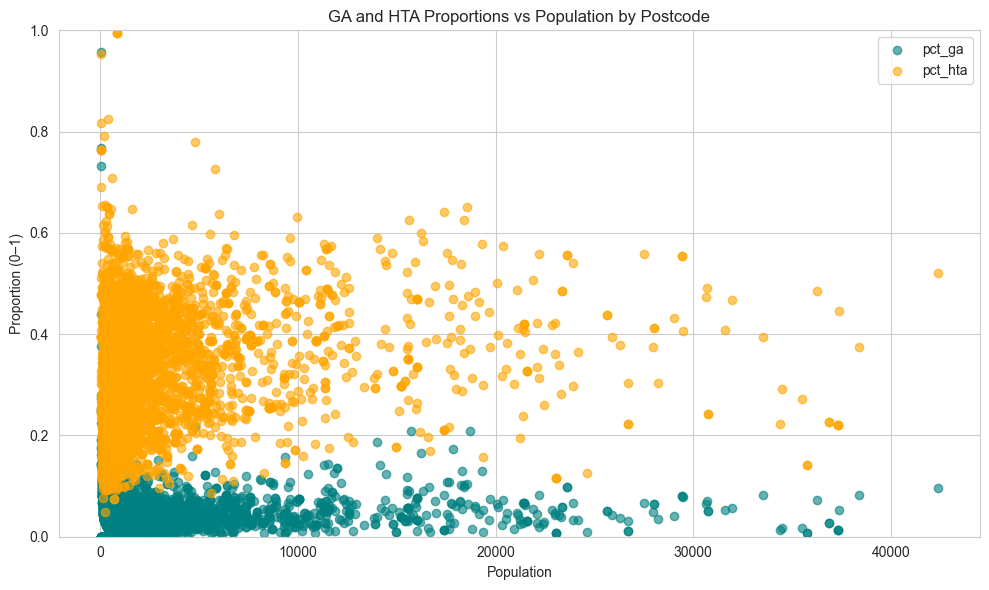

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(gdf_merged['population'], gdf_merged['pct_ga'], label='pct_ga', alpha=0.6, color='teal')
plt.scatter(gdf_merged['population'], gdf_merged['pct_hta'], label='pct_hta', alpha=0.6, color='orange')
plt.xlabel('Population')
plt.ylabel('Proportion (0–1)')
plt.ylim(0, 1)
plt.title('GA and HTA Proportions vs Population by Postcode')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/9c/8kt_75q92qv2p6wzt_p0h8tr0000gn/T/ipykernel_65125/2140387448.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return Point(gdf_clean[gdf_clean['cluster_kmeans'] == cluster_id]['geometry'].unary_union.centroid)  # If you have a 'geometry' column
/var/folders/9c/8kt_75q92qv2p6wzt_p0h8tr0000gn/T/ipykernel_65125/2140387448.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return Point(gdf_clean[gdf_clean['cluster_kmeans'] == cluster_id]['geometry'].unary_union.centroid)  # If you have a 'geometry' column
/var/folders/9c/8kt_75q92qv2p6wzt_p0h8tr0000gn/T/ipykernel_65125/2140387448.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return Point(gdf_clean[gdf_clean['cluster_kmeans'] == cluster_id]['geometry'].unary_union.centroid)  # If you have a 'geometry' column
/var/folders/9c/8kt_75q92qv2p6wzt_p0h

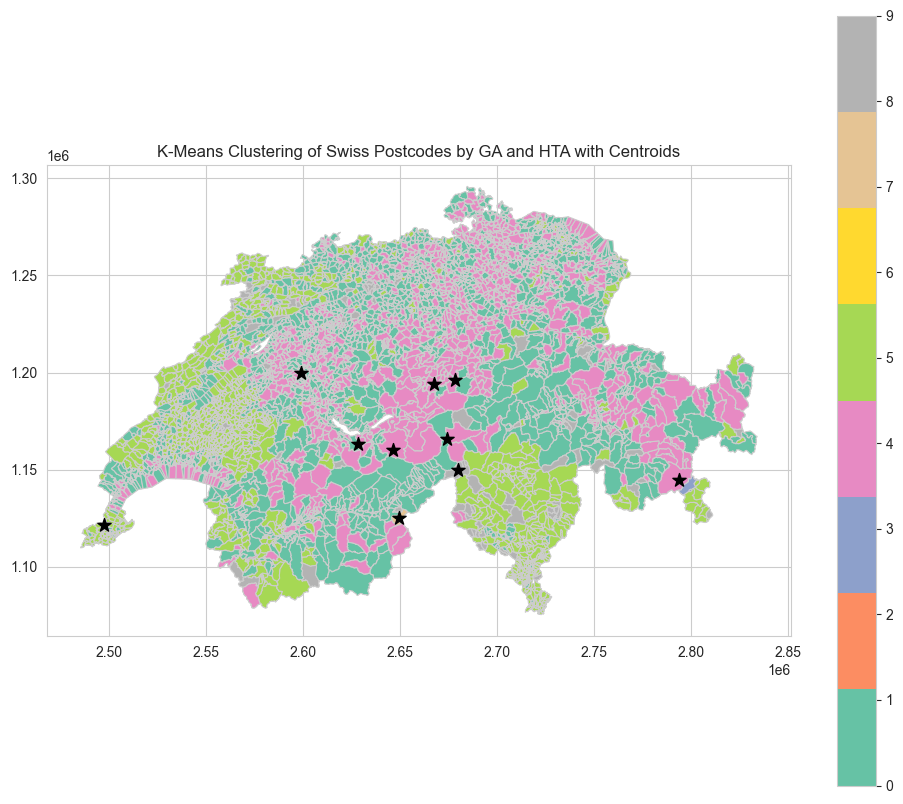

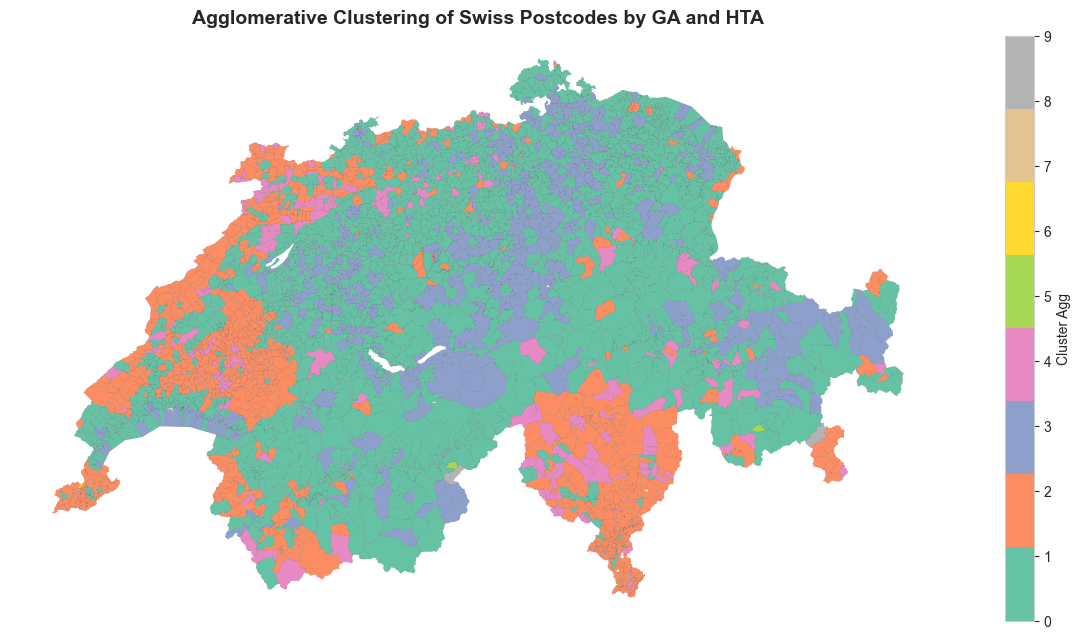

K-Means Cluster Averages:
                  pct_ga    pct_hta
cluster_kmeans                     
0               0.090499   0.523959
1               0.032722   0.316063
2               5.757895  11.500000
3               0.000000   3.816239
4               0.042674   0.421200
5               0.021904   0.196947
6               0.956505   4.000000
7               0.000000   5.724359
8               0.578506   0.801865
9               0.097651   0.251321

Agglomerative Clustering Averages:
               pct_ga    pct_hta
cluster_agg                     
0            0.092614   0.499650
1            0.033159   0.329808
2            0.019273   0.194148
3            0.044345   0.443873
4            0.066652   0.213635
5            0.749652   1.017664
6            0.956505   4.000000
7            5.757895  11.500000
8            0.000000   5.724359
9            0.000000   3.816239


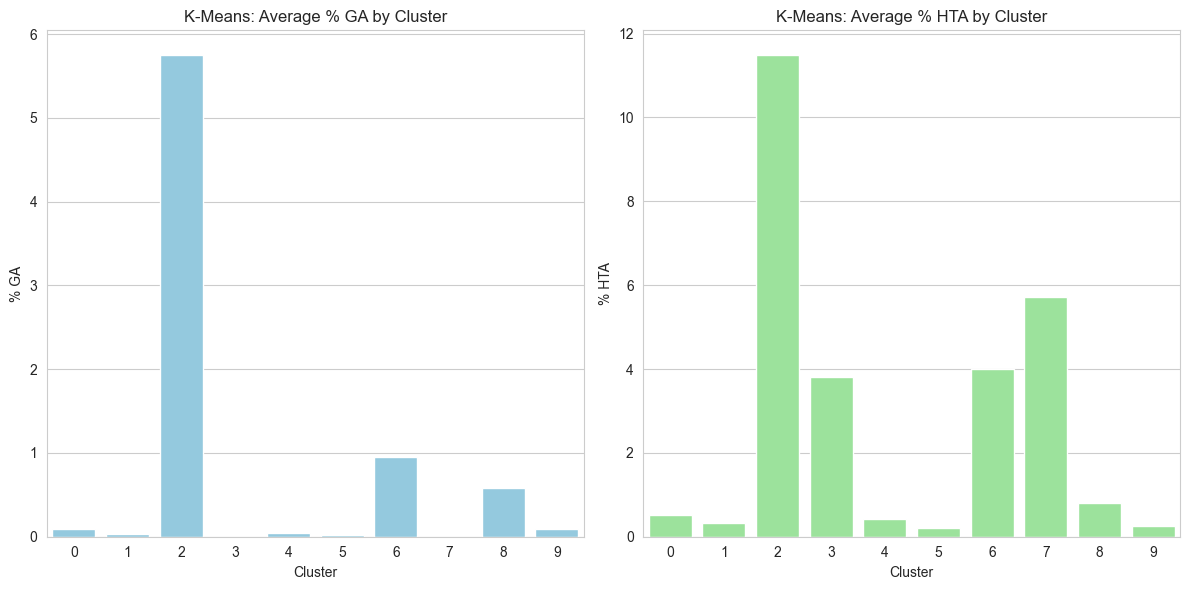

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

features = gdf_merged[['pct_ga', 'pct_hta']]
features = features.replace([np.inf, -np.inf], np.nan).dropna()
gdf_clean = gdf_merged.loc[features.index].copy()

# 1. K-Means Clustering (as before)
features_scaled = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=10, random_state=42)
gdf_clean['cluster_kmeans'] = kmeans.fit_predict(features_scaled)

# Get K-Means centroids
centroids_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=['pct_ga_centroid', 'pct_hta_centroid'])

# 2. Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10)  # Using same number of clusters for comparison
gdf_clean['cluster_agg'] = agg_clustering.fit_predict(features_scaled)


# 3. Plotting Cluster Centroids on Map (for K-Means)
# Need to create a GeoDataFrame for the centroids
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Assuming the original gdf_merged has coordinate information (e.g., 'longitude', 'latitude' or 'geometry')
# If you don't have it, you'll need to join the centroid dataframe with another dataframe that has the coordinates
# For this example, I'll assume you have a way to get representative points for each cluster (e.g., the mean coordinates of the postcodes in the cluster)
# Replace this with your actual method to get centroid coordinates
def get_representative_point(cluster_id):
    # This is a placeholder! Replace with your actual logic to get a representative point
    # For example, you might calculate the mean longitude/latitude of postcodes in the cluster
    return Point(gdf_clean[gdf_clean['cluster_kmeans'] == cluster_id]['geometry'].unary_union.centroid)  # If you have a 'geometry' column

centroid_points = [get_representative_point(i) for i in range(10)]
centroids_gdf = GeoDataFrame(centroids_kmeans, geometry=centroid_points)

# Modified plot_map function to also plot centroids
def plot_map_with_centroids(gdf, column, title, cmap, centroids_gdf=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf.plot(column=column, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    if centroids_gdf is not None:
        centroids_gdf.plot(ax=ax, marker='*', color='black', markersize=100)  # Plot centroids as stars
    ax.set_title(title)
    plt.show()

plot_map_with_centroids(gdf_clean, 'cluster_kmeans', "K-Means Clustering of Swiss Postcodes by GA and HTA with Centroids", cmap='Set2', centroids_gdf=centroids_gdf)
plot_map(gdf_clean, 'cluster_agg', "Agglomerative Clustering of Swiss Postcodes by GA and HTA", cmap='Set2')


# 4. Table of Aggregate Values
def aggregate_cluster_values(gdf, cluster_column, value_columns):
    """Aggregates values by cluster and returns a DataFrame."""
    return gdf.groupby(cluster_column)[value_columns].mean()

aggregate_kmeans = aggregate_cluster_values(gdf_clean, 'cluster_kmeans', ['pct_ga', 'pct_hta'])
aggregate_agg = aggregate_cluster_values(gdf_clean, 'cluster_agg', ['pct_ga', 'pct_hta'])


print("K-Means Cluster Averages:")
print(aggregate_kmeans)

print("\nAgglomerative Clustering Averages:")
print(aggregate_agg)


# 5. (Optional) Visualization of Cluster Profiles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=aggregate_kmeans.index, y='pct_ga', data=aggregate_kmeans.reset_index(), ax=axes[0], color='skyblue')
axes[0].set_title('K-Means: Average % GA by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('% GA')

sns.barplot(x=aggregate_kmeans.index, y='pct_hta', data=aggregate_kmeans.reset_index(), ax=axes[1], color='lightgreen')
axes[1].set_title('K-Means: Average % HTA by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('% HTA')

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have gdf_merged and plot_map defined as in your original code

# 1. Prepare Data
features = gdf_merged[['pct_ga', 'pct_hta']].dropna()
features_scaled = StandardScaler().fit_transform(features)

# 2. Initial K-Means Clustering
n_clusters = 10  # You can adjust this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
gdf_merged['cluster_kmeans_initial'] = kmeans.fit_predict(features_scaled)

# 3. Merge Small Clusters Function
def merge_small_clusters(gdf, cluster_column, min_size, features_scaled):
    """Merges clusters smaller than min_size with their nearest neighbor."""

    cluster_counts = gdf[cluster_column].value_counts()
    small_clusters = cluster_counts[cluster_counts < min_size].index.tolist()

    if not small_clusters:
        return gdf

    for small_cluster in small_clusters:
        small_cluster_indices = gdf[gdf[cluster_column] == small_cluster].index
        small_cluster_points = features_scaled[small_cluster_indices]

        # Find the nearest larger cluster
        large_clusters = cluster_counts[cluster_counts >= min_size].index.tolist()
        nearest_large_cluster = None
        min_distance = float('inf')

        for large_cluster in large_clusters:
            large_cluster_indices = gdf[gdf[cluster_column] == large_cluster].index
            large_cluster_points = features_scaled[large_cluster_indices]
            # Calculate the distance between all points in the small cluster and all points in the large cluster
            distances = euclidean_distances(small_cluster_points, large_cluster_points)
            # Find the minimum distance
            cluster_min_distance = np.min(distances)
            if cluster_min_distance < min_distance:
                min_distance = cluster_min_distance
                nearest_large_cluster = large_cluster

        # Merge the small cluster into the nearest large cluster
        gdf.loc[small_cluster_indices, cluster_column] = nearest_large_cluster

    return gdf

# 4. Apply Merging
min_cluster_size = 10
gdf_merged['cluster_kmeans_merged'] = gdf_merged['cluster_kmeans_initial'].copy()  # Start with a copy
gdf_merged = merge_small_clusters(gdf_merged, 'cluster_kmeans_merged', min_cluster_size, features_scaled)

# Run the merging process multiple times until no more small clusters
while True:
    cluster_counts = gdf_merged['cluster_kmeans_merged'].value_counts()
    if (cluster_counts < min_cluster_size).sum() == 0:
        break
    gdf_merged = merge_small_clusters(gdf_merged, 'cluster_kmeans_merged', min_cluster_size, features_scaled)

# 5. Plot the Merged Clusters
plot_map(gdf_merged, 'cluster_kmeans_merged', f"K-Means Clustering (Merged, Min Size={min_cluster_size})", cmap='Set2')

# 6. Show Percentage Distribution
cluster_percentage = gdf_merged['cluster_kmeans_merged'].value_counts(normalize=True) * 100
print("Cluster Percentage Distribution:")
print(cluster_percentage)

# 7. (Optional) Visualize Cluster Proportions
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_percentage.index, y=cluster_percentage.values, palette='viridis')
plt.title('Percentage of Postcodes in Each Cluster (Merged)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.show()

ValueError: Length of values (4052) does not match length of index (4072)